(170,)


/Users/robertshahn/anaconda3/envs/wrf-proj/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


wrf stats = 14.24
bcwrf stats = 12.6508771815


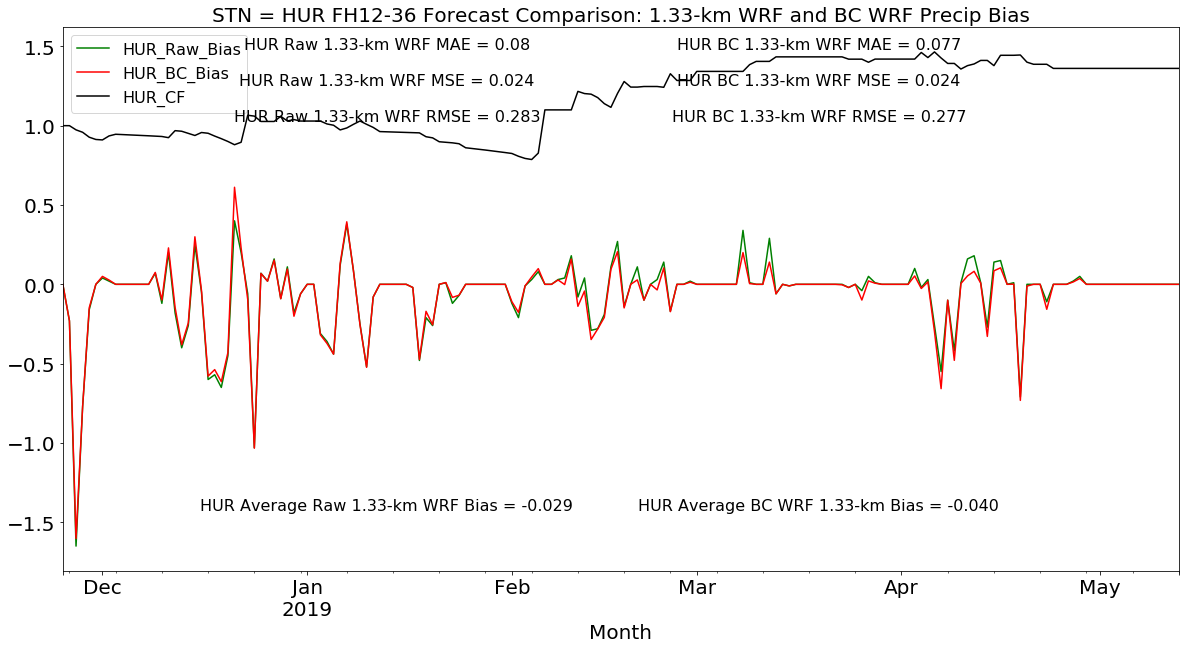

wrf stats = 46.67
bcwrf stats = 38.3351056561


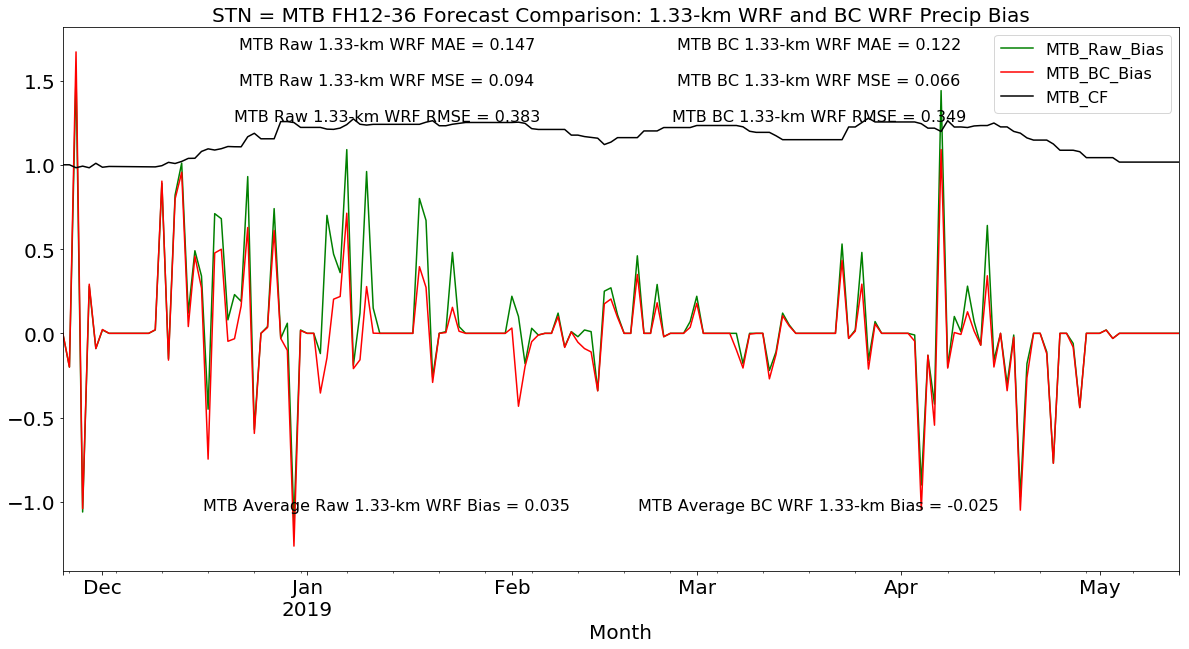

wrf stats = 19.68
bcwrf stats = 9.70721985412


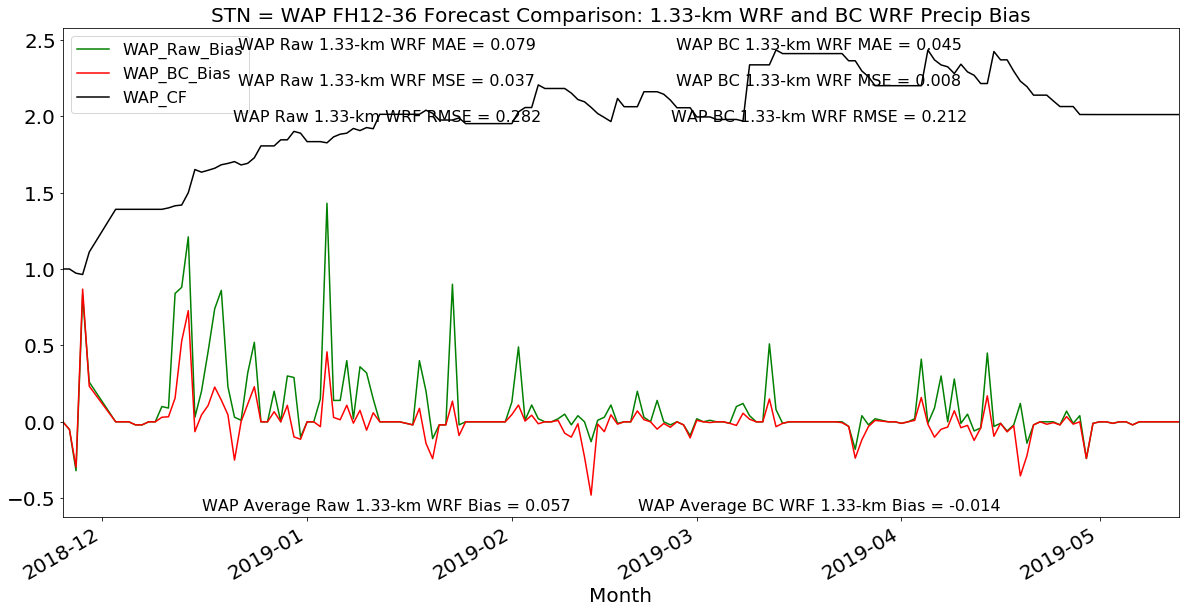

wrf stats = 30.22
bcwrf stats = 15.4900271453


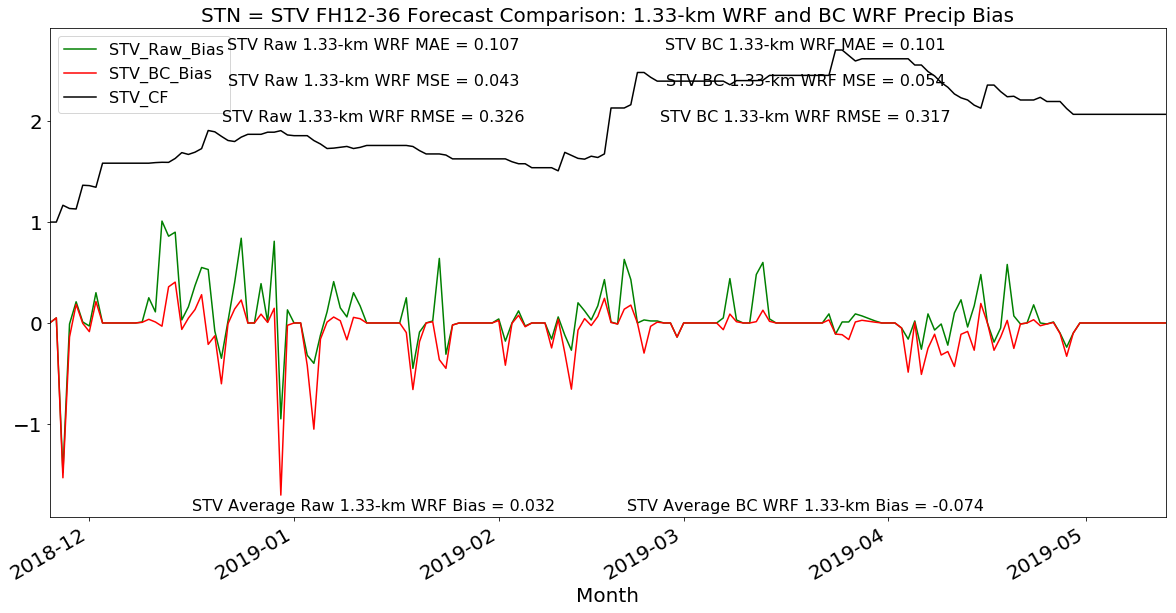

wrf stats = 30.85
bcwrf stats = 28.3865076787


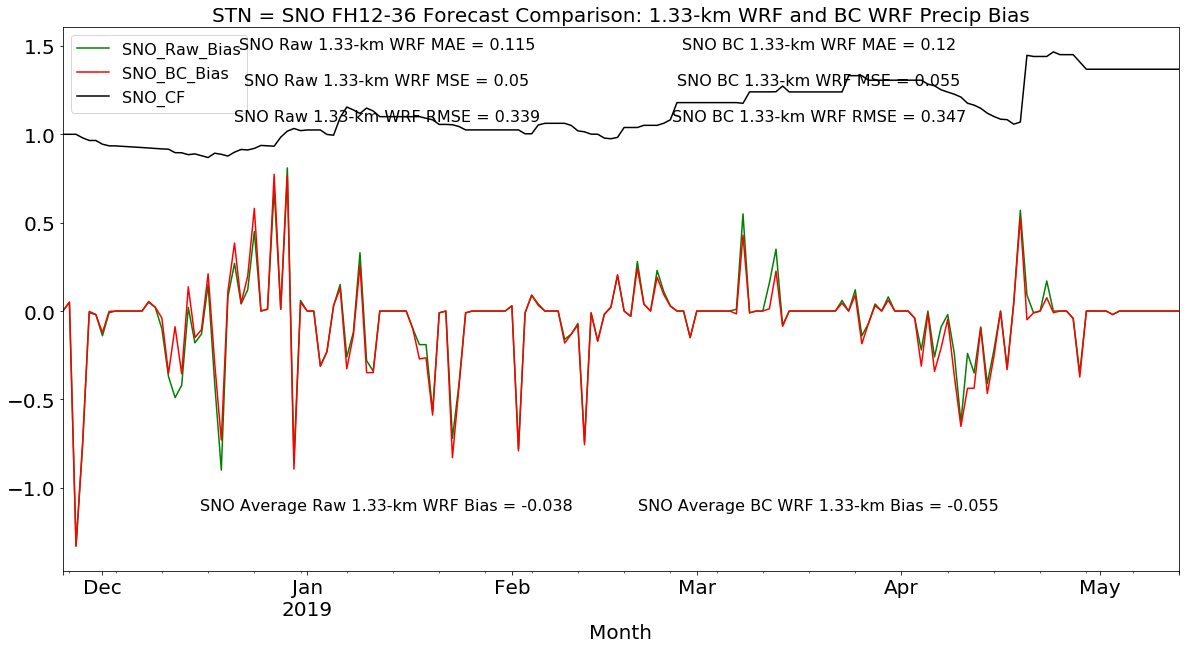

wrf stats = 5.99
bcwrf stats = 5.50615179405


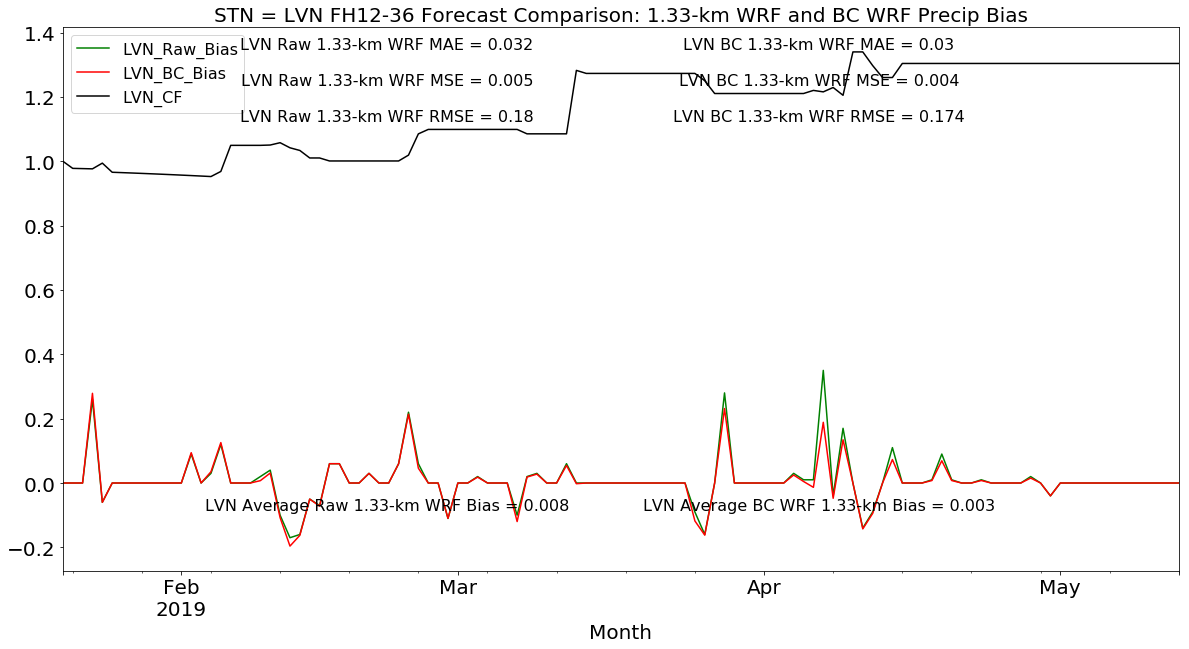

wrf stats = 14.82
bcwrf stats = 4.81087943842


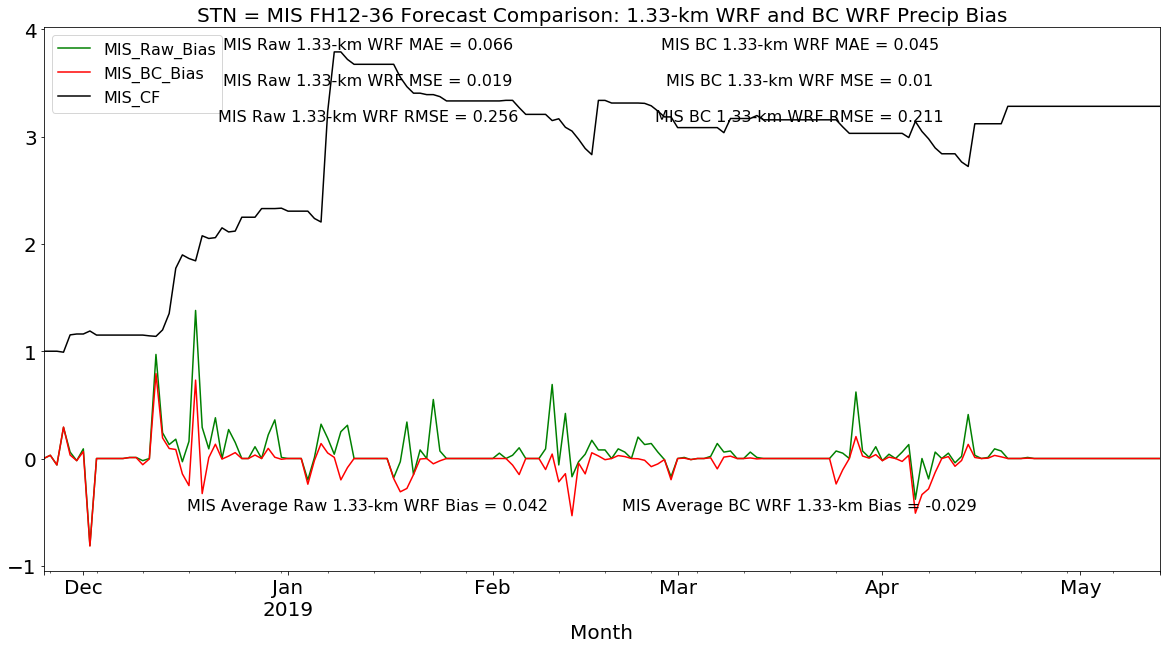

wrf stats = 24.57
bcwrf stats = 16.4138845157


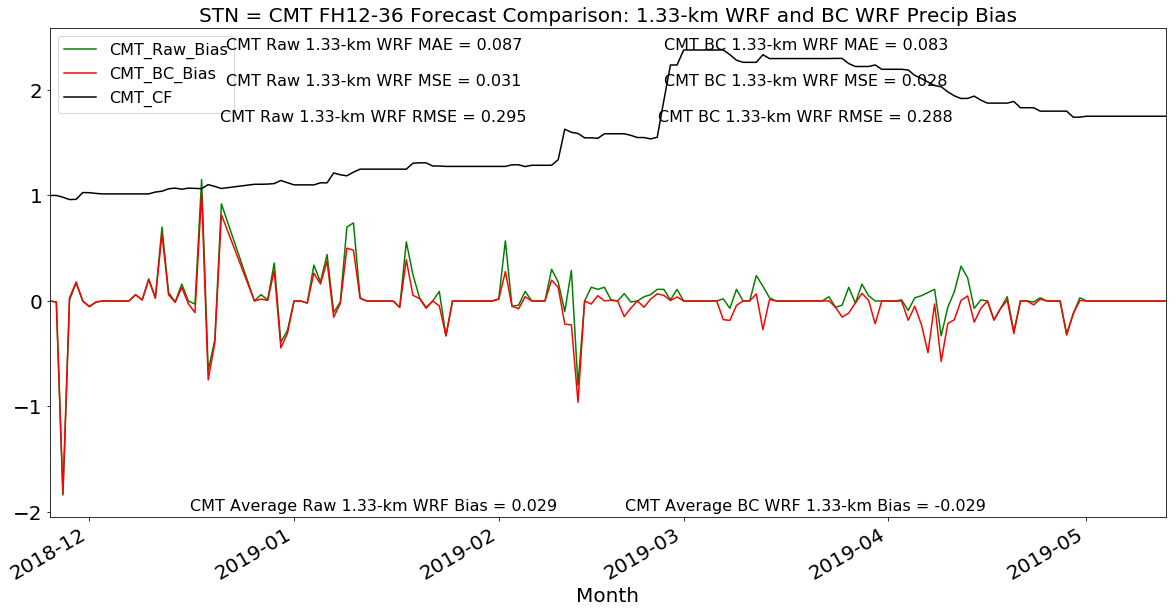

In [ ]:
import datetime
from datetime import date
import seaborn as sns

import copy

#from datetime import date_range
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics  

import os
import os.path

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.close("all")

def plotFigure(data_plot,file_name,order):
    fig = plt.figure(order, figsize=(9, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_plot)
    fig.savefig(file_name, bbox_inches='tight')
    plt.close()
    
proj_dir   = '/Users/robertshahn/Documents/python-projects/BiasCorrection'

data_file = os.path.join(proj_dir,'BiasCorrectionData_new.csv')

#date_rng = pd.date_range(start='12/11/2018', end='4/30/2019', freq='D')
date_rng = pd.date_range(start='11/25/2018', end='5/13/2019', freq='D')
print(date_rng.shape)


df = pd.read_csv(data_file)
df.columns = df.columns.str.strip() 
pd.options.display.float_format = '{:,.2f}'.format
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.iloc[0:170,:]
#print(df.shape)

#df.truncate(after=112)

df['Date'] = date_rng
df = df.set_index('Date')

#correction_factor = [(tau - 1)/tau]*yesterdays_factor + (1/tau)*(most_recent_fcst_pcp/most_recent_obs_pcp)

columns = ['HUR2','MTB2','WAP2','STV2','SNO2','LVN2','MIS2','CMT2','PAR2','WHP2','TML2','MHM2', \
          'HUR3','MTB3','WAP3','STV3','SNO3','LVN3','MIS3','CMT3','PAR3','WHP3','TML3','MHM3']
#correction_factor = [(tau - 1)/tau]*yesterdays_factor + (1/tau)*(most_recent_fcst_pcp/most_recent_obs_pcp)
names = ['HUR','MTB','WAP','STV','SNO','LVN','MIS','CMT','PAR','WHP','TML','MHM']
#names = ['HUR']
df.drop(columns, inplace=True, axis=1)
#names = ['STV']
for name in names:
    df2 = copy.deepcopy(df.filter(regex=name)).dropna(axis=0, how='any')
    obs = df2[name+'1']
    fcst = df2[name+'4']
    df2[name+'_CF'] = 0
    cf = df2[name+'_CF']
    df2[name+'_BC'] = 0
    bc_fcst = df2[name+'_BC']
    df2[name+'_Raw_Bias'] = 0
    raw_bias = df2[name+'_Raw_Bias']
    df2[name+'_BC_Bias'] = 0
    bc_bias = df2[name+'_BC_Bias']
    cf.iloc[0] = 1
    tau = 30
    #cf.iloc[0] = 1
    #print(cf.head())
#    unchanged = True
    for i in range(1,len(df2)):

        if (obs.iloc[i-1]==0.0 or fcst.iloc[i-1]==0.0 or np.isnan(obs.iloc[i-1])==True or np.isnan(fcst.iloc[i-1])==True):
            if(cf.iloc[i-1]>1):
                cf.iloc[i] = cf.iloc[i-1]+(cf.iloc[i-1]-1)*1/30
            if(cf.iloc[i-1]<1):
                cf.iloc[i] = cf.iloc[i-1]-(1-cf.iloc[i-1])*1/30
            else:
                cf.iloc[i] = cf.iloc[i-1]
#            print(str(cf.iloc[i]) + "   " + str(cf.iloc[i-1]))
#             print("cf IS " + str(cf.iloc[i]))
#             print("cf+1 IS = " + str(cf.iloc[i+1]))
        else:
    #        unchanged = False
    #       print("j = " + str(i))
    #         print(round(fcst.iloc[i],3))
    #        cf.iloc[i+1] = ((tau - 1)/tau)*cf.iloc[i] + (1/tau)*(fcst.iloc[i]/obs.iloc[i])
            cf.iloc[i] = ((tau - 1)/tau)*cf.iloc[i-1] + (1/tau)*(fcst.iloc[i-1]/obs.iloc[i-1])
            #code to avoid large jumps in cf
            if(abs((cf.iloc[i]/cf.iloc[i-1]))>1.5):
                cf.iloc[i] = cf.iloc[i-1]+(cf.iloc[i]-cf.iloc[i-1])/(cf.iloc[i]+cf.iloc[i-1])
        bc_fcst.iloc[i] = fcst.iloc[i]/cf.iloc[i]
        bc_bias.iloc[i] = bc_fcst.iloc[i] - obs.iloc[i]
        raw_bias.iloc[i] = fcst.iloc[i] - obs.iloc[i]
#         print("i = " + str(i) + "; date is " + str(df2.index.date[i]) + "; fcst df2 is " + str(round(fcst.iloc[i],2)) + "; obs is " + str(round(obs.iloc[i],2)) + "; cf is " + str(round(cf.iloc[i],2)) + \
#             "; fcst_bc is " + str(round(df2[name+'_BC'].iloc[i],2)))

        import copy
 #       df2 = copy.deepcopy(df.filter(regex=name))
        a = open(proj_dir+'/'+name+'_precip.txt', 'w')
        a.write(str(df2))
        a.close()         

#     raw_bias = fcst - obs
#     bc_bias = bc_fcst - obs
        #drop rows with nan
#    df3 = copy.deepcopy(df2.dropna(axis=0, how='any'))
#    print(df3)
    fig = plt.figure(figsize=(16,16))
    raw_bias.plot(figsize=(20,10), fontsize=20, color="green")
    bc_bias.plot(figsize=(20,10), fontsize=20, color="red")
#     bc_fcst.plot(figsize=(20,10), fontsize=20, color="blue")
#     fcst.plot(figsize=(20,10), fontsize=20, color="magenta")
#     obs.plot(figsize=(20,10), fontsize=20, color="orange")
    cf.plot(figsize=(20,10), fontsize=20, color="black")
    
    plt.xlabel('Month', fontsize=20)
    obs_stats = df2[name+'1'].loc['2018-12-25 00:00:00':'2019-05-13 00:00:00']
    wrf_stats = df2[name+'4'].loc['2018-12-25 00:00:00':'2019-05-13 00:00:00']
    bcwrf_stats = df2[name+'_BC'].loc['2018-12-25 00:00:00':'2019-05-13 00:00:00']
    print("wrf stats = " + str(sum(wrf_stats)))
    print("bcwrf stats = " + str(sum(bcwrf_stats)))
    plt.figtext(0.35, 0.85,name+" Raw 1.33-km WRF MAE = " + str(round(metrics.mean_absolute_error(wrf_stats,obs_stats),3)), wrap=True,
                horizontalalignment='center', fontsize=16)
    plt.figtext(0.35, 0.8,name+" Raw 1.33-km WRF MSE = " + str(round(metrics.mean_squared_error(wrf_stats,obs_stats),3)), wrap=True,
                horizontalalignment='center', fontsize=16)
    plt.figtext(0.35, 0.75,name+" Raw 1.33-km WRF RMSE = " + str(round(np.sqrt(metrics.mean_absolute_error(wrf_stats,obs_stats)),3)), 
                wrap=True, horizontalalignment='center', fontsize=16)
    plt.figtext(0.35, 0.21,name+" Average Raw 1.33-km WRF Bias = " + str(round((wrf_stats-obs_stats).mean(),3)), wrap=True,
                horizontalalignment='center', fontsize=16)
    plt.figtext(0.65, 0.85,name+" BC 1.33-km WRF MAE = " + str(round(metrics.mean_absolute_error(bcwrf_stats,obs_stats),3)), wrap=True,
                horizontalalignment='center', fontsize=16)
    plt.figtext(0.65, 0.8,name+" BC 1.33-km WRF MSE = " + str(round(metrics.mean_squared_error(bcwrf_stats,obs_stats),3)), wrap=True,
                horizontalalignment='center', fontsize=16)
    plt.figtext(0.65, 0.75,name+" BC 1.33-km WRF RMSE = " + str(round(np.sqrt(metrics.mean_absolute_error(bcwrf_stats,obs_stats)),3)), 
                wrap=True, horizontalalignment='center', fontsize=16)
    plt.figtext(0.65, 0.21,name+" Average BC WRF 1.33-km Bias = " + str(format((bcwrf_stats-obs_stats).mean(), '.3f')), wrap=True,
                horizontalalignment='center', fontsize=16)

    plt.legend(fontsize=16)
    plt.title("STN = " + name + " FH12-36 Forecast Comparison: 1.33-km WRF and BC WRF Precip Bias", fontsize=20)
    plt.show()
    fig.savefig(proj_dir+'/STN='+name+'_WRF_vs_BCWRF.png',dpi=180)
    plt.close()
        
